In [5]:
import random
import numpy as np
from tqdm import tqdm
import copy
from pyqubo import Array, Constraint

def generate_set_cover_problem(universe_size, num_subsets, coverage_prob):
    """
    Generate a random Set Cover Problem instance.

    Args:
        universe_size (int): Number of elements in the universe U.
        num_subsets (int): Number of subsets to generate.
        coverage_prob (float): Probability that an element is included in a subset (sparsity).

    Returns:
        universe (set): The universe of elements U.
        subsets (dict): A dictionary of subsets, where keys are subset indices and values are sets of elements.
    """
    # Create the universe U
    universe = {f"e{i}" for i in range(1, universe_size + 1)}
    
    # Generate subsets
    subsets = {}
    for i in range(1, num_subsets + 1):
        subset = {e for e in universe if random.random() < coverage_prob}
        subsets[i] = subset
    
    # Ensure the universe is fully covered (optional, enforce test cases)
    for element in universe:
        if not any(element in subsets[i] for i in subsets):
            chosen_subset = random.choice(list(subsets.keys()))
            subsets[chosen_subset].add(element)
    
    return universe, subsets

# Example usage
universe_size = 10   # Number of elements in the universe
num_subsets = 5      # Number of subsets
coverage_prob = 0.5  # Sparsity: Probability an element is in a subset

universe, subsets = generate_set_cover_problem(universe_size, num_subsets, coverage_prob)



def map_to_sets(input):
    """
    Maps an np.array-based representation to a set-based representation.

    Parameters:
        input (tuple): A tuple containing:
            - V_L: np.array of L nodes
            - V_S: np.array of S nodes
            - Edges: np.array adjacency matrix (L x S)

    Returns:
        tuple: universe (set of all elements), subsets (dict mapping L nodes to their subsets of S nodes)
    """
    V_L, V_S, edges = input

    universe = set()

    for i in range(len(V_S)):
        universe.add(f"e{i+1}")

    subsets = {}

    for i in range(len(V_L)):
        subsets[i+1] = set()
        for j in range(len(V_S)):
            if edges[i, j] == 1:
                subsets[i+1].add(f"e{j+1}")
    return universe, subsets

def maximum_coverage(universe, subsets, total):
    """
    Compute the maximum coverage of each element in the universe.

    Args:
        universe (set): The universe of elements U.
        subsets (dict): A dictionary of subsets, where keys are subset indices and values are sets of elements.
        total (int): The total number of elements in the universe.

    Returns:
        np.array: An array of integers, where each element i is the maximum coverage of element i in the universe.
    """
    length = len(universe)
    result = np.zeros(length)
    index = -1
    for i in range(total):
        curr = "e"+str(i+1)
        if curr in universe:
            index += 1
            #print("curr", curr)
            for val in subsets.values():
                # print("val", val)
                if curr in val:
                    result[index] += 1

    return result.astype(int)


def preprocessing(universe, subsets):
    """
    Preprocess the set cover problem instance by removing redundant subsets and fixing the definitely necessary sets.

    Args:
        universe (set): The universe of elements U.
        subsets (dict): A dictionary of subsets, where keys are subset indices and values are sets of elements.

    Returns:
        tuple: universe (set of all elements), subsets (dict mapping L nodes to their subsets of S nodes),
                already_true (dict of sets that are definitely necessary),
                already_false (dict of sets that are definitely not necessary),
                universe (set of all elements),
                old_subsets (dict of the original subsets)
    """
    old_subsets = copy.deepcopy(subsets)
    # print("old", old_subsets)
    go = True
    result = list(subsets.items())
    # print("result", result)
    already_false = {}
    already_true = {}
    already_removed = set()
    save = result.copy()

    while go:

        go = False

        # Compare each set with every other set
        for i, set1 in enumerate(result):
            for j, set2 in enumerate(result):
                # Skip comparing a set with itself
                if i > j:
                    if set1[1].issubset(set2[1]):
                        already_false[save[i][0]] = save[i][1]
                        break
                    elif set2[1].issubset(set1[1]):
                        already_false[save[j][0]] = save[j][1]
                        break

        result = [s if s not in already_false.items() else (s[0], set()) for s in result]

        maxima = maximum_coverage(universe, {i: s for (i, s) in result}, len(universe))
        # print("maxima", maxima)
        for i, m in enumerate(maxima):
            if m not in already_removed and m == 1:
                for j, s in enumerate(result):
                    if 'e'+str(i+1) in s[1]:
                        already_true[save[j][0]] = save[j][1]   
                        for k in list(s[1]):
                            for l, s2 in enumerate(result):
                                if k in s2[1] and l != j:
                                    go = True
                                    result[l][1].remove(k)
                            already_removed.add(k)
                        break

    length = len(result)
    for i in range(length):
        if not result[i]:
            already_false.append(save[i])

    new_result = []

    for s in result:
        if s[0] not in already_false and s[0] not in already_true:
            new_result.append(s)

    new_result = [s for s in result if s[0] not in already_false and s[0] not in already_true]

    
    # Remove the subset sets
    return universe-already_removed, {s[0]: s[1] for s in new_result}, already_true, already_false, universe, old_subsets

### Definition and solution of the problem using a classical algorithm

In [6]:
from pyqubo import Array, Constraint

# Generate a random Set Cover Problem instance
universe_size = 6
num_subsets = 6
coverage_prob = 0.5


# Preprocess the problem instance
universe, subsets, already_true, already_false, old_universe, old_subsets = preprocessing(*generate_set_cover_problem(universe_size, num_subsets, coverage_prob))

# Trivially solve the problem if it is already solved
if not universe or not subsets:
    print(old_universe, already_true, already_false)
    print("Already solved")
    res = [0]*num_subsets
    print("already_true", already_true)
    for i, s in already_true.items():
        res[i-1] = 1
    print("Result:", res)

else:
    print("Universe (U):", universe)
    print(subsets)

    maxima = maximum_coverage(universe, subsets, len(old_universe))

    num_bin = np.ceil(np.log2(maxima)).astype(int)

    num_extra = int(np.sum(num_bin))

    print("Universe (U):", universe)
    print("\nSubsets (S):")
    for idx, subset in subsets.items():
        print(f"Subset {idx}: {subset}")

    # Map subsets to their elements
    subset_indices = sorted(list(subsets.keys()))
    print(subset_indices)
    element_to_subsets = {e: [] for e in universe}

    for subset, elements in subsets.items():
        for e in elements:
            element_to_subsets[e].append(subset)

    # Define binary variables for each subset
    x = Array.create('x', shape=len(subset_indices), vartype='BINARY')

    y = Array.create('y', shape=int(np.sum(num_bin)), vartype='BINARY')

    # Objective: Minimize the number of subsets selected
    objective = sum(x[i] for i in range(len(subset_indices)))

    # Constraints: Ensure each element is covered
    constraints = []
    offset = 0
    for j, (e, covering_subsets) in enumerate(element_to_subsets.items()):
        # print("covering_subsets", covering_subsets)
        constraint = sum(x[subset_indices.index(i)] for i in covering_subsets)
        slack = sum(2**i*y[offset + i] for i in range(num_bin[j]))
        constraints.append(Constraint((1 - constraint + slack)**2, label=f"cover_{e}"))
        offset += int(num_bin[j])

    # Combine objective and constraints into a QUBO model
    alpha = 1.0  # Weight for the objective
    beta = 10.0 # len(subsets) + 1   # Weight for the constraints
    combined_expression = alpha * objective + beta * sum(constraints)

    # Compile the expression to create a Model
    qubo_model = combined_expression.compile()

    bqm = qubo_model.to_bqm()

    # Print the QUBO for visualization
    print("QUBO:", bqm)

    # Solve the QUBO (e.g., using a classical solver)
    from neal import SimulatedAnnealingSampler
    sampler = SimulatedAnnealingSampler()
    response = sampler.sample(bqm, num_reads=100)

    # Extract the best solution
    best_solution = response.first.sample
    energy = response.first.energy

    print("\nBest Solution:")
    for i, val in best_solution.items():
        print(f"Subset {i}: {'Selected' if val == 1 else 'Not Selected'}")
    print(f"\nEnergy: {energy} + {len(already_true)}")

    # Decode the solution
    decoded_solution = qubo_model.decode_sample(best_solution, vartype="BINARY")
    print("\nDecoded Solution:", decoded_solution)

Universe (U): {'e4', 'e1', 'e6', 'e2', 'e5'}
{3: {'e1', 'e6', 'e5', 'e4'}, 4: {'e1', 'e6', 'e2', 'e4'}, 6: {'e6', 'e2', 'e4', 'e5'}}
Universe (U): {'e4', 'e1', 'e6', 'e2', 'e5'}

Subsets (S):
Subset 3: {'e1', 'e6', 'e5', 'e4'}
Subset 4: {'e1', 'e6', 'e2', 'e4'}
Subset 6: {'e6', 'e2', 'e4', 'e5'}
[3, 4, 6]
QUBO: BinaryQuadraticModel({'x[2]': -39.0, 'y[3]': 80.0, 'x[0]': -39.0, 'y[6]': 80.0, 'y[5]': 30.0, 'y[0]': 30.0, 'y[4]': 30.0, 'x[1]': -39.0, 'y[2]': 30.0, 'y[1]': 30.0}, {('y[3]', 'x[2]'): -40.0, ('x[0]', 'x[2]'): 60.0, ('x[0]', 'y[3]'): -40.0, ('y[6]', 'x[2]'): -40.0, ('y[6]', 'x[0]'): -40.0, ('y[5]', 'x[2]'): -20.0, ('y[5]', 'x[0]'): -20.0, ('y[5]', 'y[6]'): 40.0, ('y[0]', 'x[2]'): -20.0, ('y[0]', 'x[0]'): -20.0, ('y[4]', 'x[2]'): -20.0, ('x[1]', 'x[2]'): 60.0, ('x[1]', 'y[3]'): -40.0, ('x[1]', 'x[0]'): 60.0, ('x[1]', 'y[0]'): -20.0, ('x[1]', 'y[4]'): -20.0, ('y[2]', 'x[2]'): -20.0, ('y[2]', 'y[3]'): 40.0, ('y[2]', 'x[0]'): -20.0, ('y[2]', 'x[1]'): -20.0, ('y[1]', 'x[0]'): -20.0, 

### Visualization of the corresponding bipartite graph

[(3, {'e1', 'e6', 'e5', 'e4'}), (4, {'e1', 'e6', 'e2', 'e4'}), (6, {'e6', 'e2', 'e4', 'e5'})]
Fulfills condition:  True
universe {'e4', 'e1', 'e6', 'e2', 'e5'}
[{'e1', 'e5'}, {'e3'}, {'e1', 'e6', 'e5', 'e4'}, {'e1', 'e6', 'e2', 'e4'}, {'e5'}, {'e6', 'e2', 'e4', 'e5'}]
[2, 3, 6]


/var/folders/zj/89qtcvw17sqblpw8pjkrvr3m0000gn/T/ipykernel_29315/1039907052.py:55: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


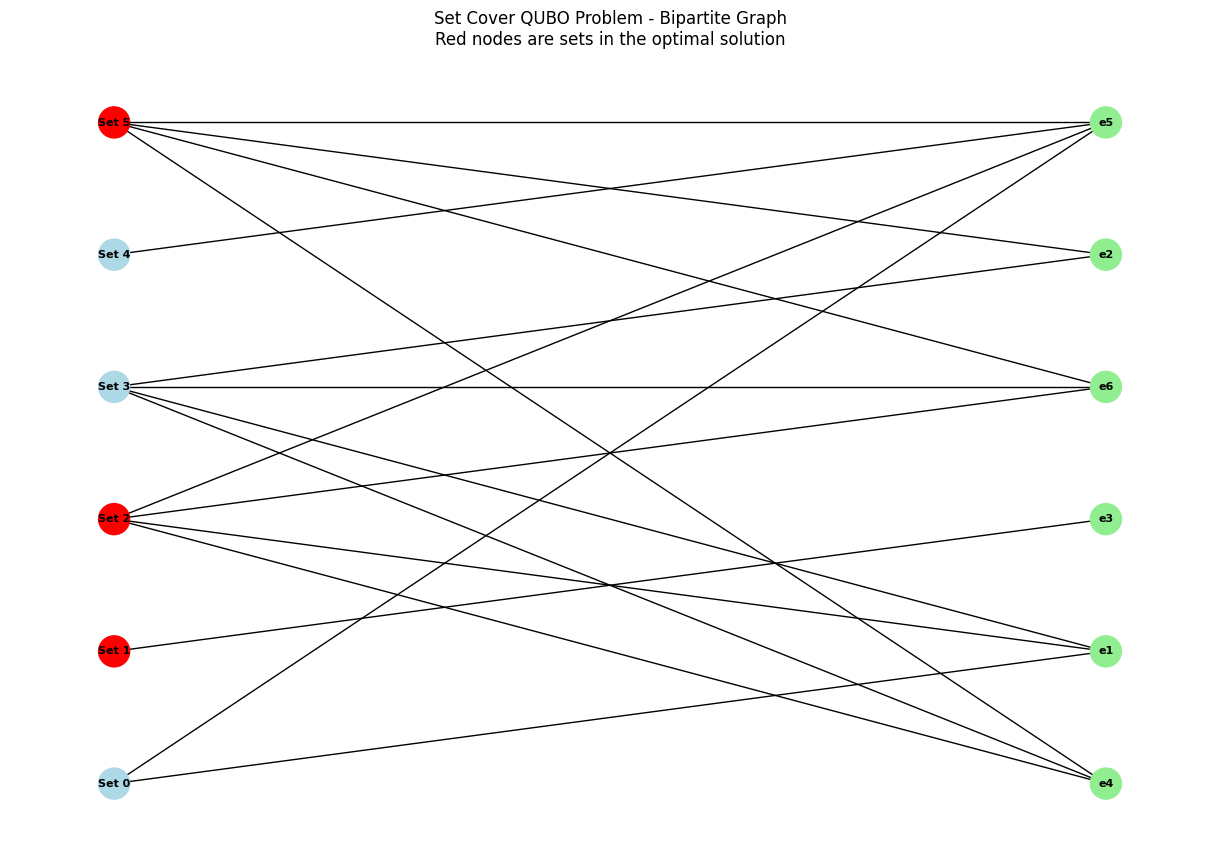

In [7]:
import networkx as nx
import matplotlib.pyplot as plt


def visualize_set_cover_qubo(sets, optimal_solution):
    """
    Visualize the Set Cover QUBO problem as a bipartite graph.

    Args:
        sets (list): A list of sets, where each set is a list of elements.
        optimal_solution (list): A list of subset indices that are part of the optimal solution.
    """
    # Create a bipartite graph
    G = nx.Graph()
    
    # Add nodes for sets (left side)
    set_nodes = [f'Set {i}' for i in range(len(sets))]
    G.add_nodes_from(set_nodes, bipartite=0)
    
    # Collect all unique elements (right side)
    all_elements = set.union(*sets)
    element_nodes = list(all_elements)
    G.add_nodes_from(element_nodes, bipartite=1)
    
    # Add edges
    for i, s in enumerate(sets):
        for elem in s:
            G.add_edge(f'Set {i}', elem)
    
    # Prepare for visualization
    pos = nx.bipartite_layout(G, set_nodes)
    
    # Color mapping
    node_colors = []
    for node in G.nodes():
        if node in set_nodes:
            # Highlight sets in the optimal solution
            color = 'red' if node in [f'Set {i-1}' for i in optimal_solution] else 'lightblue'
            node_colors.append(color)
        else:
            node_colors.append('lightgreen')
    
    # Plot
    plt.figure(figsize=(12, 8))
    nx.draw(G, pos, 
            with_labels=True, 
            node_color=node_colors, 
            node_size=500, 
            font_size=8, 
            font_weight='bold')
    
    # Add a title explaining the visualization
    plt.title("Set Cover QUBO Problem - Bipartite Graph\nRed nodes are sets in the optimal solution")
    
    plt.tight_layout()
    plt.show()

resulting_set = set()

test = sorted(list(subsets.items()))

print(test)

result = [key for key in already_true.keys()]

for i in range(len(subsets)):
    if best_solution[f'x[{i}]']:
        result.append(subset_indices[i])
        resulting_set |= test[i][1]

result = sorted(result)

print("Fulfills condition: ", resulting_set==universe)

all_sorted = sorted(list(old_subsets.items()))

print("universe", universe)

print([s[1] for s in all_sorted])
print(result)

visualize_set_cover_qubo([s[1] for s in all_sorted], result)

### Solving the problem using the dimod SimulatedAnnealingSampler

In [8]:
from dimod import BinaryQuadraticModel, SimulatedAnnealingSampler

# Use the SimulatedAnnealingSampler from dimod for simulation
sampler = SimulatedAnnealingSampler()
response = sampler.sample(bqm, num_reads=100)

# Extract the best solution
best_solution = response.first.sample
energy = response.first.energy

print("\nBest Solution (Simulated Annealing):")
for i, val in best_solution.items():
    print(f"Variable {i}: {'1' if val == 1 else '0'}")
print(f"\nEnergy: {energy} + {len(already_true)}")


Best Solution (Simulated Annealing):
Variable x[0]: 1
Variable x[1]: 1
Variable x[2]: 0
Variable y[0]: 1
Variable y[1]: 1
Variable y[2]: 1
Variable y[3]: 0
Variable y[4]: 0
Variable y[5]: 0
Variable y[6]: 0

Energy: 2.0 + 1


### Solving the problem using QAOA

In [10]:
from qiskit import QuantumCircuit
from qiskit_algorithms import QAOA
from qiskit_algorithms.optimizers import COBYLA
from qiskit.quantum_info import SparsePauliOp
from qiskit.primitives import Sampler
from qiskit_algorithms.utils import algorithm_globals
from qiskit.quantum_info import Statevector

# Set random seed for reproducibility
algorithm_globals.random_seed = 42

# Assuming qubo_model is already defined
# Convert QUBO model to Ising representation
linear, quadratic, offset = qubo_model.to_ising()

lookup = {f'x[{i}]': i for i in range(len(subset_indices))}

for i in range(num_extra):
    lookup[f'y[{i}]'] = len(subset_indices) + i

# Print the Ising model coefficients
print("Linear coefficients:", linear)
print("Quadratic coefficients:", quadratic)
print("Energy offset:", offset)

# Construct the Hamiltonian for QAOA
hamiltonian_terms = []


num_qubits = len(subset_indices) + num_extra
# Add linear terms
for qubit, coefficient in linear.items():
    new = ["I"]*num_qubits
    new[lookup[qubit]] = 'Z'
    hamiltonian_terms.append(("".join(new), coefficient)) 



# Add quadratic terms
for (qubit1, qubit2), coefficient in quadratic.items():
    if qubit1 != qubit2:
        # Create an interaction term between two qubits
        term = ['I'] * num_qubits
        term[lookup[qubit1]] = 'Z'
        term[lookup[qubit2]] = 'Z'

        hamiltonian_terms.append((''.join(term), coefficient))

# Create SparsePauliOp Hamiltonian
hamiltonian = SparsePauliOp.from_list(hamiltonian_terms)

# Print the Hamiltonian
print("Hamiltonian:")
print(hamiltonian)

# Set up QAOA parameters
reps = 5  # Number of QAOA layers
optimizer = COBYLA(maxiter=100)

# Initialize QAOA
qaoa = QAOA(sampler=Sampler(), optimizer=optimizer, reps=reps)

# Run QAOA to find the minimum eigenvalue of the Hamiltonian
result = qaoa.compute_minimum_eigenvalue(operator=hamiltonian)

eigenvector = bin(max(result.eigenstate, key=result.eigenstate.get))[2:]

eigenvector = eigenvector.zfill(num_qubits)

print("Eigenvector:", eigenvector)

eigdict = {f"x[{i}]": int(eigenvector[i]) for i in range(len(subset_indices))}

for i in range(num_extra):
    eigdict[f"y[{i}]"] = int(eigenvector[len(subset_indices) + i])  

# Display the result
print("\nBest solution found:")
print(f"Minimum eigenvalue: {Statevector.from_label(eigenvector).expectation_value(hamiltonian)+offset}")
print("Optimal bitstring:", eigenvector)

Linear coefficients: {'x[0]': -29.5, 'x[1]': -19.5, 'x[2]': -29.5, 'y[6]': 30.0, 'y[1]': 5.0, 'y[2]': 10.0, 'y[3]': 20.0, 'y[4]': 5.0, 'y[5]': 15.0}
Quadratic coefficients: {('x[0]', 'x[1]'): 15.0, ('x[0]', 'y[1]'): -5.0, ('x[0]', 'y[0]'): -5.0, ('x[0]', 'x[2]'): 15.0, ('x[2]', 'y[4]'): -5.0, ('x[1]', 'y[0]'): -5.0, ('x[2]', 'y[2]'): -5.0, ('x[0]', 'y[6]'): -10.0, ('x[1]', 'x[2]'): 15.0, ('x[2]', 'y[3]'): -10.0, ('x[2]', 'y[5]'): -5.0, ('x[1]', 'y[1]'): -5.0, ('x[0]', 'y[3]'): -10.0, ('x[0]', 'y[5]'): -5.0, ('x[0]', 'y[2]'): -5.0, ('x[1]', 'y[3]'): -10.0, ('x[1]', 'y[2]'): -5.0, ('x[1]', 'y[4]'): -5.0, ('x[2]', 'y[0]'): -5.0, ('x[2]', 'y[6]'): -10.0, ('y[2]', 'y[3]'): 10.0, ('y[5]', 'y[6]'): 10.0}
Energy offset: 101.5
Hamiltonian:
SparsePauliOp(['ZIIIIIIIII', 'IZIIIIIIII', 'IIZIIIIIII', 'IIIIIIIIIZ', 'IIIIZIIIII', 'IIIIIZIIII', 'IIIIIIZIII', 'IIIIIIIZII', 'IIIIIIIIZI', 'ZZIIIIIIII', 'ZIIIZIIIII', 'ZIIZIIIIII', 'ZIZIIIIIII', 'IIZIIIIZII', 'IZIZIIIIII', 'IIZIIZIIII', 'ZIIIIIIIIZ', 'IZZII

/var/folders/zj/89qtcvw17sqblpw8pjkrvr3m0000gn/T/ipykernel_29315/4108709220.py:61: DeprecationWarning: The class ``qiskit.primitives.sampler.Sampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Sampler` class is `StatevectorSampler`.
  qaoa = QAOA(sampler=Sampler(), optimizer=optimizer, reps=reps)


Eigenvector: 0000001011

Best solution found:
Minimum eigenvalue: (33+0j)
Optimal bitstring: 0000001011


### Solving the problem on an analogue quantum device

In [11]:
from dwave.system import EmbeddingComposite, DWaveSampler


dwave_token = "DEV-fbd89b618f4d7e7cb055489c62dfae7e1b1912e0"

sampler = EmbeddingComposite(DWaveSampler(token=dwave_token))
response = sampler.sample(bqm, num_reads=100)

best_solution = response.first.sample
energy = response.first.energy

print("\nBest Solution on D-Wave:")
for i, val in best_solution.items():
    print(f"Subset {i}: {'Selected' if val == 1 else 'Not Selected'}")
print(f"\nEnergy: {energy} + {len(already_true)}")


Best Solution on D-Wave:
Subset x[0]: Selected
Subset x[1]: Selected
Subset x[2]: Not Selected
Subset y[0]: Selected
Subset y[1]: Selected
Subset y[2]: Selected
Subset y[3]: Not Selected
Subset y[4]: Not Selected
Subset y[5]: Not Selected
Subset y[6]: Not Selected

Energy: 2.0 + 1


### Define a pipeline to run the different optimization algorithms for multiple rounds and then compare them

In [ ]:
import numpy as np
from tqdm import tqdm
def pipeline(sizearray, runs=100, preprocess=False):
    output = np.zeros((len(sizearray), 2, runs))
    for m, size in enumerate(sizearray):
        print("Size: ", size)
        for n in tqdm(range(runs)):
            universe, subsets = generate_set_cover_problem(size, size, 0.5)
            old_universe = copy.deepcopy(universe)
            old_subsets = copy.deepcopy(subsets)
            already_false = {}
            already_true = {}
            if preprocess:
                universe, subsets, already_true, already_false, old_universe, old_subsets = preprocessing(universe, subsets)
            if not universe or not subsets:
                res = [0]*size
                for i, s in already_true.items():
                    res[i-1] = 1
                output[m, :, n] = 2*[sum(res)]
            else:
                maxima = maximum_coverage(universe, subsets, len(old_universe))
                num_bin = np.ceil(np.log2(maxima)).astype(int)
                num_extra = int(np.sum(num_bin))
                subset_indices = sorted(list(subsets.keys()))
                element_to_subsets = {e: [] for e in universe}
                for subset, elements in subsets.items():
                    for e in elements:
                        element_to_subsets[e].append(subset)
                x = Array.create('x', shape=len(subset_indices), vartype='BINARY')
                y = Array.create('y', shape=int(np.sum(num_bin)), vartype='BINARY') if int(np.sum(num_bin)) else []
                objective = sum(x[i] for i in range(len(subset_indices)))
                constraints = []
                offset = 0
                for j, (e, covering_subsets) in enumerate(element_to_subsets.items()):
                    constraint = sum(x[subset_indices.index(i)] for i in covering_subsets)
                    slack = sum(2**i*y[offset + i] for i in range(num_bin[j])) if y else 0
                    constraints.append(Constraint((1 - constraint + slack)**2, label=f"cover_{e}"))
                    offset += int(num_bin[j])
                alpha = 1.0
                beta = 10.0
                combined_expression = alpha * objective + beta * sum(constraints)
                qubo_model = combined_expression.compile()
                bqm = qubo_model.to_bqm()

                # Solve the QUBO (e.g., using a classical solver)
                from neal import SimulatedAnnealingSampler
                sampler = SimulatedAnnealingSampler()
                response = sampler.sample(bqm, num_reads=100)

                # Extract the best solution
                best_solution = response.first.sample
                energy = response.first.energy


                output[m, 0, n] = energy + len(already_true)

                # Decode the solution
                decoded_solution = qubo_model.decode_sample(best_solution, vartype="BINARY")
                from dwave.system import EmbeddingComposite, DWaveSampler
                dwave_token = "DEV-fbd89b618f4d7e7cb055489c62dfae7e1b1912e0"
                sampler = EmbeddingComposite(DWaveSampler(token=dwave_token))
                response = sampler.sample(bqm, num_reads=100)
                best_solution = response.first.sample
                energy = response.first.energy
                output[m, -1, n] = energy + len(already_true)
    return output

### Execute pipeline

In [14]:
sizearray = np.arange(1, 11, 1)

preprocess = False

output = pipeline(sizearray, runs=10, preprocess=preprocess)

Size:  1


100%|██████████| 10/10 [00:26<00:00,  2.68s/it]


Size:  2


100%|██████████| 10/10 [00:27<00:00,  2.74s/it]


Size:  3


100%|██████████| 10/10 [00:26<00:00,  2.61s/it]


Size:  4


100%|██████████| 10/10 [00:27<00:00,  2.77s/it]


Size:  5


100%|██████████| 10/10 [00:27<00:00,  2.75s/it]


Size:  6


100%|██████████| 10/10 [00:27<00:00,  2.72s/it]


Size:  7


100%|██████████| 10/10 [00:29<00:00,  2.90s/it]


Size:  8


100%|██████████| 10/10 [00:27<00:00,  2.80s/it]


Size:  9


100%|██████████| 10/10 [00:29<00:00,  2.95s/it]


Size:  10


100%|██████████| 10/10 [00:33<00:00,  3.33s/it]


### Save the data in as .npy

In [ ]:
# Save to file
import datetime
current_date = datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
np.save(f"{current_date}_({sizearray[0]},{sizearray[-1]})_preprocess={preprocess}.npy", output)

### Import combined data and plot

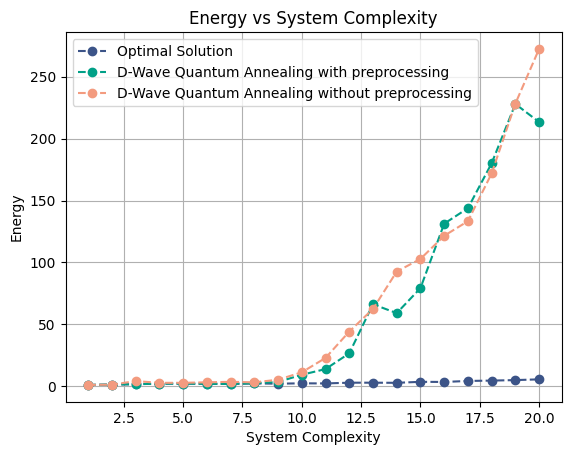

In [ ]:
names = ["2024-12-01_08-50-12_(1,10)_preprocess=True.npy", "2024-12-01_09-18-45_(11,20)_preprocess=True.npy", "2024-12-01_09-57-44_(1,10)_preprocess=False.npy", "2024-12-01_09-48-36_(11,20)_preprocess=False.npy"]

outputs = [np.load(name) for name in names]
new_true = np.zeros((20, 3, 10))
new_true[:10, :2, :] = outputs[0]
new_true[10:, :2, :] = outputs[1]
new_true[:10, 2, :] = outputs[2][:, 1, :]
new_true[10:, 2, :] = outputs[3][:, 1, :]


import matplotlib.pyplot as plt

# colors
color_red = "#e64b35"
color_light_red = "#f39b7f"
color_green = "#00a087"
color_lightblue = "#4dbbd5"
color_blue = "#3c5488"
colors = [color_blue, color_lightblue, color_green, color_light_red, color_red]

fig, ax = plt.subplots()

ax.plot(np.arange(1, 21, 1), np.mean(new_true[:, 0], axis=-1), marker='o', linestyle = 'dashed', color = colors[0], label = 'Optimal Solution')
ax.plot(np.arange(1, 21, 1), np.mean(new_true[:, 1], axis=-1), marker='o', linestyle = 'dashed', color = colors[2], label = 'D-Wave Quantum Annealing with preprocessing')
ax.plot(np.arange(1, 21, 1), np.mean(new_true[:, 2], axis=-1), marker='o', linestyle = 'dashed', color = colors[3], label = 'D-Wave Quantum Annealing without preprocessing')
ax.grid(True)
ax.set_xlabel('System Complexity')
ax.set_ylabel('Energy')
ax.set_title('Energy vs System Complexity')
ax.legend()

fig.savefig('runtime.pdf')
